## **Обнаружение грязных тарелок**

В данной работе обучается нейросеть, способная отделять чистые тарелки от грязных. Особенностью обучения является ограниченность тренировочных данных (40 изображений). Для расширения обучающей выборки применяется аугментация изображений. Также в данной работе используется техника transfer learning на основе предобученной сети resnet. Результатом является csv-файл с id тарелки и меткой класса. Метрика качества accuracy, итоговый результать составил 90%.
<br>Ссылка на соревнование:https://www.kaggle.com/competitions/platesv2


In [ ]:
import numpy as np 
import pandas as pd 

# Input data files are available in the "../input/" directory.


import os
print(os.listdir("../input"))
print(os.getcwd())
# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
/kaggle/working
After zip extraction:
['submission.csv', '__notebook_source__.ipynb', 'plates', '__MACOSX']


In [ ]:
print(os.getcwd())

/kaggle/working


In [ ]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        #if i % 6 != 0:
        dest_dir = os.path.join(train_dir, class_name) 
        #else:
        #    dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))











  0%|          | 0/21 [00:00<?, ?it/s]









100%|██████████| 21/21 [00:00<00:00, 2166.05it/s]









  0%|          | 0/21 [00:00<?, ?it/s]









100%|██████████| 21/21 [00:00<00:00, 3358.00it/s]

In [ ]:
!ls train

cleaned  dirty


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.CenterCrop((150, 150)),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.3, hue=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#коэффициенты уже предобученной сети
])

val_transforms = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.CenterCrop((150, 150)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
#val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
#val_dataloader = torch.utils.data.DataLoader(
    #val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
len(train_dataloader), len(train_dataset)

(5, 40)

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 40
    Root location: train

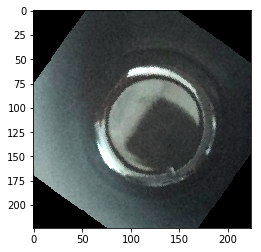

In [ ]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);


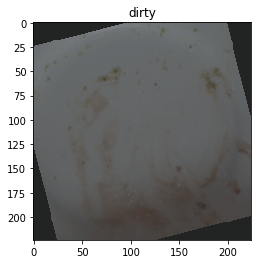

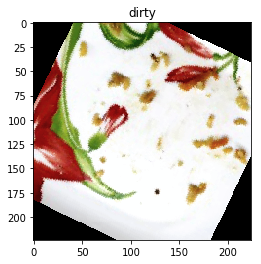

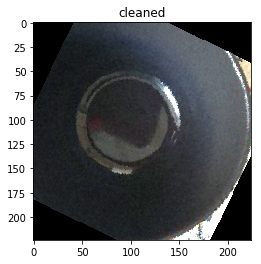

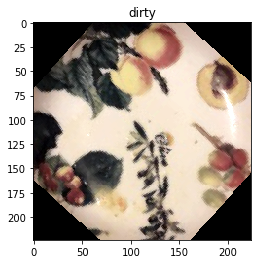

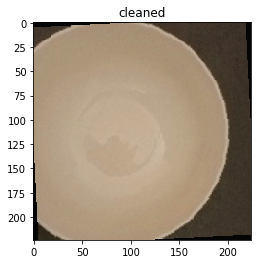

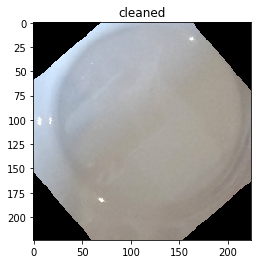

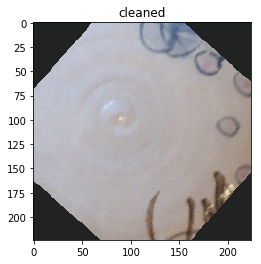

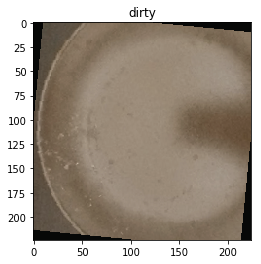

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    """
    Данная функция реализует обучение нейросети
    """
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1))

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            #else:
                #dataloader = val_dataloader
                #model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.
            

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
                        

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    return model

Создание дополнительных слоев предобученной сети

In [ ]:
    model = models.resnet34(pretrained=True)

    # Disable grad for all conv layers
    for param in model.parameters():
        param.requires_grad = False


    model.fc = torch.nn.Sequential(
                    torch.nn.Linear(model.fc.in_features, 256),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(256, 128),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 64),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(64, 2))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.3)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)

#model.fc.in_features

In [ ]:
model = train_model(model, loss, optimizer, scheduler, num_epochs=60);

Epoch 0/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.27it/s]









 60%|██████    | 3/5 [00:00<00:00,  4.33it/s]









100%|██████████| 5/5 [00:00<00:00,  5.61it/s]

train Loss: 0.7064 Acc: 0.3500
Epoch 1/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.17it/s]









 60%|██████    | 3/5 [00:00<00:00,  4.19it/s]









100%|██████████| 5/5 [00:00<00:00,  8.61it/s]

train Loss: 0.6979 Acc: 0.4250
Epoch 2/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.34it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.74it/s]









100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

train Loss: 0.6949 Acc: 0.5000
Epoch 3/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

train Loss: 0.6893 Acc: 0.5750
Epoch 4/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.94it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.34it/s]









100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

train Loss: 0.6740 Acc: 0.6750
Epoch 5/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.12it/s]









100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

train Loss: 0.6823 Acc: 0.5500
Epoch 6/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.47it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.91it/s]









100%|██████████| 5/5 [00:00<00:00, 11.67it/s]

train Loss: 0.6605 Acc: 0.7000
Epoch 7/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00, 11.29it/s]

train Loss: 0.6741 Acc: 0.6750
Epoch 8/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.06it/s]









100%|██████████| 5/5 [00:00<00:00, 11.41it/s]

train Loss: 0.6423 Acc: 0.7250
Epoch 9/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.56it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.91it/s]









100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

train Loss: 0.6569 Acc: 0.6000
Epoch 10/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.54it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.05it/s]









100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

train Loss: 0.6297 Acc: 0.7250
Epoch 11/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.69it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.06it/s]









100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

train Loss: 0.6129 Acc: 0.7500
Epoch 12/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.91it/s]









100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

train Loss: 0.6300 Acc: 0.7250
Epoch 13/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.01it/s]









100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

train Loss: 0.5908 Acc: 0.8250
Epoch 14/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.77it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.12it/s]









100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

train Loss: 0.6234 Acc: 0.7500
Epoch 15/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.54it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.01it/s]









100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

train Loss: 0.6067 Acc: 0.7000
Epoch 16/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.92it/s]









100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

train Loss: 0.5924 Acc: 0.7750
Epoch 17/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.58it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.91it/s]









100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

train Loss: 0.5557 Acc: 0.8500
Epoch 18/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.92it/s]









100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

train Loss: 0.5754 Acc: 0.7750
Epoch 19/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.94it/s]









100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

train Loss: 0.5920 Acc: 0.7500
Epoch 20/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.72it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

train Loss: 0.5329 Acc: 0.8250
Epoch 21/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.54it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.88it/s]









100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

train Loss: 0.5358 Acc: 0.7750
Epoch 22/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.46it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.87it/s]









100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

train Loss: 0.5440 Acc: 0.8250
Epoch 23/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.73it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.12it/s]









100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

train Loss: 0.5340 Acc: 0.7500
Epoch 24/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.37it/s]









 40%|████      | 2/5 [00:00<00:00,  4.98it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.01it/s]









100%|██████████| 5/5 [00:00<00:00,  8.03it/s]

train Loss: 0.5307 Acc: 0.8500
Epoch 25/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.78it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 10.79it/s]

train Loss: 0.5184 Acc: 0.8000
Epoch 26/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.27it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.58it/s]









100%|██████████| 5/5 [00:00<00:00, 10.67it/s]

train Loss: 0.5614 Acc: 0.7500
Epoch 27/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

train Loss: 0.4907 Acc: 0.9250
Epoch 28/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.45it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

train Loss: 0.5450 Acc: 0.8250
Epoch 29/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.61it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.11it/s]









100%|██████████| 5/5 [00:00<00:00,  6.91it/s]

train Loss: 0.5297 Acc: 0.8000
Epoch 30/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.31it/s]









100%|██████████| 5/5 [00:00<00:00,  4.41it/s]

train Loss: 0.4655 Acc: 0.9000
Epoch 31/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.69it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]









100%|██████████| 5/5 [00:00<00:00,  7.98it/s]

train Loss: 0.5304 Acc: 0.8250
Epoch 32/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.80it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.13it/s]









100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.5116 Acc: 0.8750
Epoch 33/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

train Loss: 0.5437 Acc: 0.7500
Epoch 34/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.51it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.98it/s]









100%|██████████| 5/5 [00:00<00:00, 11.18it/s]

train Loss: 0.4779 Acc: 0.8500
Epoch 35/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

train Loss: 0.4748 Acc: 0.8750
Epoch 36/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.99it/s]









100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

train Loss: 0.5148 Acc: 0.8500
Epoch 37/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.31it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.74it/s]









100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

train Loss: 0.5224 Acc: 0.8500
Epoch 38/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.75it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.11it/s]









100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

train Loss: 0.5581 Acc: 0.7250
Epoch 39/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.89it/s]









100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

train Loss: 0.5070 Acc: 0.8500
Epoch 40/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.59it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

train Loss: 0.4668 Acc: 0.9250
Epoch 41/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.06it/s]









100%|██████████| 5/5 [00:00<00:00, 11.32it/s]

train Loss: 0.5149 Acc: 0.8250
Epoch 42/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

train Loss: 0.4861 Acc: 0.8500
Epoch 43/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.73it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

train Loss: 0.5401 Acc: 0.7250
Epoch 44/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.69it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

train Loss: 0.5137 Acc: 0.7750
Epoch 45/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.59it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

train Loss: 0.5093 Acc: 0.8750
Epoch 46/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.32it/s]









 40%|████      | 2/5 [00:00<00:00,  4.80it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00,  8.37it/s]

train Loss: 0.5479 Acc: 0.7000
Epoch 47/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.69it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 10.59it/s]

train Loss: 0.5367 Acc: 0.7750
Epoch 48/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.88it/s]









100%|██████████| 5/5 [00:00<00:00, 10.96it/s]

train Loss: 0.5175 Acc: 0.8500
Epoch 49/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.47it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.83it/s]









100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

train Loss: 0.5267 Acc: 0.8250
Epoch 50/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.85it/s]









100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

train Loss: 0.5032 Acc: 0.7500
Epoch 51/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.46it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

train Loss: 0.5392 Acc: 0.7750
Epoch 52/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.44it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.91it/s]









100%|██████████| 5/5 [00:00<00:00, 11.64it/s]

train Loss: 0.4900 Acc: 0.8500
Epoch 53/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.50it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.76it/s]









100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

train Loss: 0.5381 Acc: 0.7750
Epoch 54/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.01it/s]









100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

train Loss: 0.4907 Acc: 0.8500
Epoch 55/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.56it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.06it/s]









100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

train Loss: 0.4908 Acc: 0.8000
Epoch 56/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.41it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 11.32it/s]

train Loss: 0.5194 Acc: 0.7750
Epoch 57/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.09it/s]









100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

train Loss: 0.5172 Acc: 0.8500
Epoch 58/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.33it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.62it/s]









100%|██████████| 5/5 [00:00<00:00, 10.76it/s]

train Loss: 0.4821 Acc: 0.8500
Epoch 59/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.70it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.01it/s]









100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

train Loss: 0.4809 Acc: 0.8500


In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))
#imagefolder внутри директории ищет папку с классом, поэтому добавлен unknown

'test/unknown'

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,)) #выводим дополнительно путь до картинки
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
test_dataset

In [ ]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
        #print(preds)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
#print(test_predictions)
test_predictions = np.concatenate(test_predictions)











  0%|          | 0/93 [00:00<?, ?it/s]









  2%|▏         | 2/93 [00:00<00:06, 15.12it/s]









  4%|▍         | 4/93 [00:00<00:05, 15.40it/s]









  6%|▋         | 6/93 [00:00<00:05, 15.69it/s]









  9%|▊         | 8/93 [00:00<00:05, 16.08it/s]









 11%|█         | 10/93 [00:00<00:05, 16.56it/s]









 13%|█▎        | 12/93 [00:00<00:04, 17.02it/s]









 15%|█▌        | 14/93 [00:00<00:04, 17.36it/s]









 17%|█▋        | 16/93 [00:00<00:04, 17.66it/s]









 19%|█▉        | 18/93 [00:01<00:04, 18.03it/s]









 22%|██▏       | 20/93 [00:01<00:03, 18.31it/s]









 24%|██▎       | 22/93 [00:01<00:03, 18.51it/s]









 26%|██▌       | 24/93 [00:01<00:03, 18.82it/s]









 28%|██▊       | 26/93 [00:01<00:03, 18.99it/s]









 30%|███       | 28/93 [00:01<00:03, 19.21it/s]









 32%|███▏      | 30/93 [00:01<00:03, 19.26it/s]









 34%|███▍      | 32/93 [00:01<00:03, 19.23it/s]









 37%|███▋      | 34/93 [00:01<00:0

In [ ]:
#test_predictions

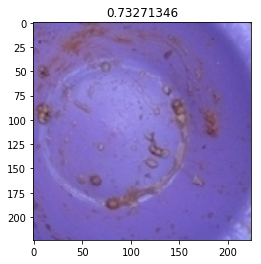

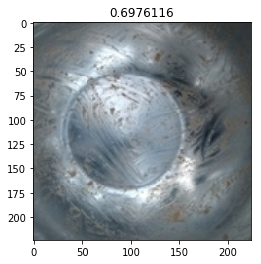

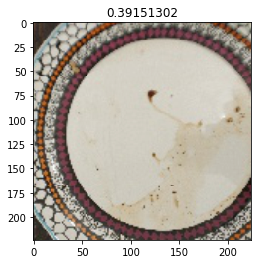

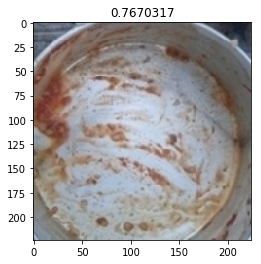

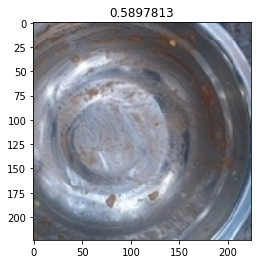

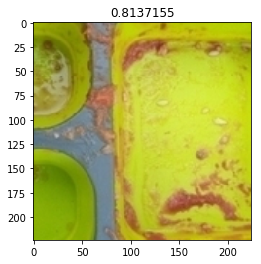

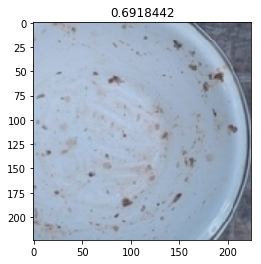

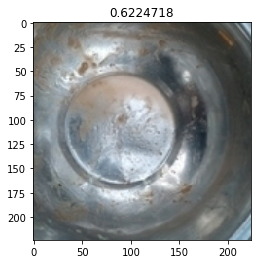

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)



In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.55 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [ ]:
def test_single(model=model, test_dataloader=test_dataloader):
    """
    функция возвращает результаты тестирования
    """
    
    model.eval()

    test_predictions = []
    test_img_paths = []
    for inputs, labels, paths in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs)
            
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        test_img_paths.extend(paths)

    
    test_predictions = np.concatenate(test_predictions)
    return test_img_paths, test_predictions

def model_init():
    """
    функция инициаизирует модель
    """
    model = models.resnet34(pretrained=True)

    # Disable grad for all conv layers
    for param in model.parameters():
        param.requires_grad = False


    model.fc = torch.nn.Sequential(
                    torch.nn.Linear(model.fc.in_features, 256),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(256, 128),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 64),
                    torch.nn.Dropout2d(0.2),
                    torch.nn.Sigmoid(),
                    torch.nn.Linear(64, 2))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.3)

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)
    return model, loss, optimizer, scheduler


In [ ]:
def test_common():
    """
    функция обучает 5 нейросетей с разными начальными условиями и возврает средний результат
    """
    frames=[]
    for i in range(5):
        model, loss, optimizer, scheduler = model_init()
        model1 = train_model(model, loss, optimizer, scheduler, num_epochs=60)
        test_img_paths, test_predictions = test_single(model=model1)
        submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
        submission_df['label'] = submission_df['label'].map(lambda pred: 1 if pred > 0.55 else 0)
        submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
        submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
        frames.append(submission_df)
    df = submission_df.copy()
    df['label']=0
    print(df)
    for i in range(5):
        df['label'] = df['label'] + frames[i]['label']
    print(df)    
    df['label'] = df['label'].map(lambda pred: 'dirty' if pred > 2 else 'cleaned')
    return df

In [ ]:
submission_df=test_common()

Epoch 0/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.29it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.53it/s]









100%|██████████| 5/5 [00:00<00:00, 10.22it/s]

train Loss: 0.7124 Acc: 0.5000
Epoch 1/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.44it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.72it/s]









100%|██████████| 5/5 [00:00<00:00, 10.31it/s]

train Loss: 0.6830 Acc: 0.5750
Epoch 2/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.47it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.83it/s]









100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

train Loss: 0.7266 Acc: 0.3750
Epoch 3/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.54it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.86it/s]









100%|██████████| 5/5 [00:00<00:00, 10.55it/s]

train Loss: 0.6788 Acc: 0.5500
Epoch 4/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.08it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.43it/s]









100%|██████████| 5/5 [00:00<00:00,  9.92it/s]

train Loss: 0.6815 Acc: 0.6000
Epoch 5/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.35it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.67it/s]









100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

train Loss: 0.6651 Acc: 0.6500
Epoch 6/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.23it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.51it/s]









100%|██████████| 5/5 [00:00<00:00, 10.20it/s]

train Loss: 0.6643 Acc: 0.6000
Epoch 7/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.29it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.63it/s]









100%|██████████| 5/5 [00:00<00:00,  9.57it/s]

train Loss: 0.6520 Acc: 0.7250
Epoch 8/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.77it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.69it/s]









100%|██████████| 5/5 [00:00<00:00,  4.83it/s]

train Loss: 0.6395 Acc: 0.8000
Epoch 9/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.99it/s]









100%|██████████| 5/5 [00:00<00:00, 10.38it/s]

train Loss: 0.6290 Acc: 0.8000
Epoch 10/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.47it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.78it/s]









100%|██████████| 5/5 [00:00<00:00, 10.43it/s]

train Loss: 0.6326 Acc: 0.7500
Epoch 11/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

train Loss: 0.5927 Acc: 0.7250
Epoch 12/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.84it/s]









100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

train Loss: 0.5775 Acc: 0.8000
Epoch 13/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.51it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

train Loss: 0.5938 Acc: 0.7000
Epoch 14/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.73it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.08it/s]









100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

train Loss: 0.5430 Acc: 0.8000
Epoch 15/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.91it/s]









100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

train Loss: 0.5913 Acc: 0.7250
Epoch 16/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.98it/s]









100%|██████████| 5/5 [00:00<00:00, 11.23it/s]

train Loss: 0.5878 Acc: 0.7250
Epoch 17/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.59it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

train Loss: 0.5536 Acc: 0.8250
Epoch 18/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

train Loss: 0.5939 Acc: 0.7000
Epoch 19/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

train Loss: 0.5741 Acc: 0.7000
Epoch 20/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

train Loss: 0.5350 Acc: 0.7750
Epoch 21/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.32it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.72it/s]









100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

train Loss: 0.4985 Acc: 0.8500
Epoch 22/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.60it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.89it/s]









100%|██████████| 5/5 [00:00<00:00, 10.75it/s]

train Loss: 0.4851 Acc: 0.8500
Epoch 23/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.95it/s]









100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

train Loss: 0.4625 Acc: 0.9000
Epoch 24/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.56it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

train Loss: 0.4539 Acc: 0.9000
Epoch 25/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.89it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.10it/s]









100%|██████████| 5/5 [00:00<00:00,  9.74it/s]

train Loss: 0.5373 Acc: 0.7250
Epoch 26/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.26it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.05it/s]









100%|██████████| 5/5 [00:00<00:00,  3.97it/s]

train Loss: 0.5349 Acc: 0.7500
Epoch 27/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.39it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.18it/s]









100%|██████████| 5/5 [00:00<00:00,  4.21it/s]

train Loss: 0.5248 Acc: 0.7250
Epoch 28/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.36it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.62it/s]









100%|██████████| 5/5 [00:00<00:00, 10.20it/s]

train Loss: 0.5236 Acc: 0.7750
Epoch 29/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.78it/s]









 40%|████      | 2/5 [00:00<00:00,  4.54it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.63it/s]









100%|██████████| 5/5 [00:00<00:00,  7.88it/s]

train Loss: 0.4671 Acc: 0.9000
Epoch 30/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.45it/s]









 80%|████████  | 4/5 [00:00<00:00,  4.66it/s]









100%|██████████| 5/5 [00:00<00:00,  9.77it/s]

train Loss: 0.4828 Acc: 0.8500
Epoch 31/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.44it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.86it/s]









100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

train Loss: 0.5046 Acc: 0.8000
Epoch 32/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.47it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]









100%|██████████| 5/5 [00:00<00:00, 11.00it/s]

train Loss: 0.5084 Acc: 0.8250
Epoch 33/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.80it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.19it/s]









100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

train Loss: 0.4826 Acc: 0.8500
Epoch 34/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.34it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.74it/s]









100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.5413 Acc: 0.7000
Epoch 35/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 10.77it/s]

train Loss: 0.4459 Acc: 0.9250
Epoch 36/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

train Loss: 0.4820 Acc: 0.8250
Epoch 37/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.95it/s]









100%|██████████| 5/5 [00:00<00:00, 10.89it/s]

train Loss: 0.4656 Acc: 0.8250
Epoch 38/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.42it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.74it/s]









100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

train Loss: 0.4832 Acc: 0.8000
Epoch 39/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.33it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.76it/s]









100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

train Loss: 0.4207 Acc: 0.8750
Epoch 40/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.77it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.29it/s]









100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

train Loss: 0.4320 Acc: 0.9000
Epoch 41/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.50it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.94it/s]









100%|██████████| 5/5 [00:00<00:00, 11.30it/s]

train Loss: 0.5003 Acc: 0.8000
Epoch 42/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.52it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.88it/s]









100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

train Loss: 0.5101 Acc: 0.7250
Epoch 43/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.63it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.13it/s]









100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

train Loss: 0.4808 Acc: 0.8500
Epoch 44/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.18it/s]









100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

train Loss: 0.4907 Acc: 0.8500
Epoch 45/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.42it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.86it/s]









100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

train Loss: 0.4871 Acc: 0.8750
Epoch 46/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.05it/s]









100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

train Loss: 0.4682 Acc: 0.8250
Epoch 47/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.46it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

train Loss: 0.4766 Acc: 0.8750
Epoch 48/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.44it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

train Loss: 0.5483 Acc: 0.8000
Epoch 49/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.65it/s]









 80%|████████  | 4/5 [00:00<00:00,  4.94it/s]









100%|██████████| 5/5 [00:00<00:00, 10.26it/s]

train Loss: 0.5515 Acc: 0.7000
Epoch 50/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.59it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.84it/s]









100%|██████████| 5/5 [00:00<00:00, 10.53it/s]

train Loss: 0.4896 Acc: 0.7750
Epoch 51/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.50it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.85it/s]









100%|██████████| 5/5 [00:00<00:00, 11.00it/s]

train Loss: 0.4842 Acc: 0.8750
Epoch 52/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.82it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]









100%|██████████| 5/5 [00:00<00:00,  4.86it/s]

train Loss: 0.4693 Acc: 0.9250
Epoch 53/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.79it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.18it/s]









100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

train Loss: 0.5060 Acc: 0.7250
Epoch 54/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.40it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.86it/s]









100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

train Loss: 0.4894 Acc: 0.7750
Epoch 55/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.03it/s]









100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

train Loss: 0.4662 Acc: 0.7750
Epoch 56/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.99it/s]









100%|██████████| 5/5 [00:00<00:00, 11.16it/s]

train Loss: 0.5172 Acc: 0.8250
Epoch 57/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.74it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.13it/s]









100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

train Loss: 0.4958 Acc: 0.8000
Epoch 58/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.70it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

train Loss: 0.4793 Acc: 0.8000
Epoch 59/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.50it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.98it/s]









100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

train Loss: 0.5132 Acc: 0.8250












  0%|          | 0/93 [00:00<?, ?it/s]









  2%|▏         | 2/93 [00:00<00:04, 18.61it/s]









  5%|▌         | 5/93 [00:00<00:04, 19.12it/s]









  9%|▊         | 8/93 [00:00<00:04, 19.55it/s]









 12%|█▏        | 11/93 [00:00<00:04, 19.77it/s]









 14%|█▍        | 13/93 [00:00<00:04, 19.67it/s]









 16%|█▌        | 15/93 [00:00<00:03, 19.74it/s]









 19%|█▉        | 18/93 [00:00<00:03, 19.95it/s]









 23%|██▎       | 21/93 [00:01<00:03, 20.11it/s]









 26%|██▌       | 24/93 [00:01<00:03, 20.27it/s]









 29%|██▉       | 27/93 [00:01<00:03, 20.37it/s]









 32%|███▏      | 30/93 [00:01<00:03, 20.41it/s]









 35%|███▌      | 33/93 [00:01<00:02, 20.39it/s]









 39%|███▊      | 36/93 [00:01<00:02, 20.38it/s]









 42%|████▏     | 39/93 [00:01<00:02, 20.35it/s]









 45%|████▌     | 42/93 [00:02<00:02, 20.25it/s]









 48%|████▊     | 45/93 [00:02<00:02, 20.27it/s]









 52%|█████▏    | 48/93 [00:02<00:

Epoch 0/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.05it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.30it/s]









100%|██████████| 5/5 [00:00<00:00,  9.94it/s]

train Loss: 0.7189 Acc: 0.5000
Epoch 1/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

train Loss: 0.6952 Acc: 0.4750
Epoch 2/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.11it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.39it/s]









100%|██████████| 5/5 [00:00<00:00, 10.37it/s]

train Loss: 0.6887 Acc: 0.5750
Epoch 3/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.78it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.17it/s]









100%|██████████| 5/5 [00:00<00:00, 10.13it/s]

train Loss: 0.6852 Acc: 0.6500
Epoch 4/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.77it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]









100%|██████████| 5/5 [00:00<00:00,  4.84it/s]

train Loss: 0.6767 Acc: 0.6250
Epoch 5/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.59it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

train Loss: 0.6711 Acc: 0.6250
Epoch 6/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.49it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.94it/s]









100%|██████████| 5/5 [00:00<00:00, 11.19it/s]

train Loss: 0.6554 Acc: 0.8000
Epoch 7/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.79it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.13it/s]









100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

train Loss: 0.6482 Acc: 0.8000
Epoch 8/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.21it/s]









100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

train Loss: 0.6425 Acc: 0.7000
Epoch 9/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 10.71it/s]

train Loss: 0.6307 Acc: 0.6750
Epoch 10/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.51it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.80it/s]









100%|██████████| 5/5 [00:00<00:00, 10.69it/s]

train Loss: 0.6076 Acc: 0.9000
Epoch 11/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

train Loss: 0.5722 Acc: 0.8000
Epoch 12/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.51it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.87it/s]









100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

train Loss: 0.5775 Acc: 0.7250
Epoch 13/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

train Loss: 0.6061 Acc: 0.7250
Epoch 14/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.38it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.83it/s]









100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

train Loss: 0.5683 Acc: 0.7750
Epoch 15/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.07it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.32it/s]









100%|██████████| 5/5 [00:00<00:00, 10.35it/s]

train Loss: 0.5499 Acc: 0.8250
Epoch 16/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

train Loss: 0.5503 Acc: 0.7750
Epoch 17/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

train Loss: 0.5201 Acc: 0.7750
Epoch 18/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.87it/s]









100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

train Loss: 0.5843 Acc: 0.7000
Epoch 19/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.06it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.11it/s]









100%|██████████| 5/5 [00:00<00:00,  6.30it/s]

train Loss: 0.5288 Acc: 0.8500
Epoch 20/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.10it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.92it/s]









100%|██████████| 5/5 [00:00<00:00,  4.91it/s]

train Loss: 0.5166 Acc: 0.8250
Epoch 21/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.60it/s]









 60%|██████    | 3/5 [00:00<00:00,  4.70it/s]









100%|██████████| 5/5 [00:00<00:00,  9.48it/s]

train Loss: 0.5577 Acc: 0.7750
Epoch 22/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.74it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.06it/s]









100%|██████████| 5/5 [00:00<00:00,  7.59it/s]

train Loss: 0.5193 Acc: 0.7750
Epoch 23/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.41it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.75it/s]









100%|██████████| 5/5 [00:00<00:00, 10.67it/s]

train Loss: 0.4626 Acc: 0.8000
Epoch 24/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.10it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.45it/s]









100%|██████████| 5/5 [00:00<00:00, 10.44it/s]

train Loss: 0.5480 Acc: 0.7500
Epoch 25/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.77it/s]









100%|██████████| 5/5 [00:00<00:00,  7.12it/s]

train Loss: 0.5262 Acc: 0.7000
Epoch 26/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.61it/s]









 60%|██████    | 3/5 [00:00<00:00,  4.65it/s]









100%|██████████| 5/5 [00:00<00:00,  5.98it/s]

train Loss: 0.4871 Acc: 0.9000
Epoch 27/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.70it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.05it/s]









100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

train Loss: 0.5152 Acc: 0.7750
Epoch 28/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.74it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.09it/s]









100%|██████████| 5/5 [00:00<00:00, 10.88it/s]

train Loss: 0.5039 Acc: 0.8250
Epoch 29/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.73it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.11it/s]









100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

train Loss: 0.4530 Acc: 0.8750
Epoch 30/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

train Loss: 0.5637 Acc: 0.6750
Epoch 31/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.75it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.12it/s]









100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

train Loss: 0.4728 Acc: 0.8250
Epoch 32/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.46it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.92it/s]









100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

train Loss: 0.5251 Acc: 0.7750
Epoch 33/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.18it/s]









100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

train Loss: 0.4904 Acc: 0.8500
Epoch 34/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.47it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.74it/s]









100%|██████████| 5/5 [00:00<00:00, 10.22it/s]

train Loss: 0.4780 Acc: 0.8250
Epoch 35/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.03it/s]









100%|██████████| 5/5 [00:00<00:00, 11.09it/s]

train Loss: 0.4640 Acc: 0.8500
Epoch 36/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.16it/s]









100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

train Loss: 0.4808 Acc: 0.8250
Epoch 37/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.70it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.05it/s]









100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

train Loss: 0.4745 Acc: 0.8500
Epoch 38/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.73it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

train Loss: 0.5106 Acc: 0.7500
Epoch 39/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.58it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.92it/s]









100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

train Loss: 0.5223 Acc: 0.7750
Epoch 40/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.58it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

train Loss: 0.4541 Acc: 0.8750
Epoch 41/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.58it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

train Loss: 0.4872 Acc: 0.8000
Epoch 42/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.60it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.13it/s]









100%|██████████| 5/5 [00:00<00:00, 11.25it/s]

train Loss: 0.5037 Acc: 0.8000
Epoch 43/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.69it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.08it/s]









100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

train Loss: 0.4559 Acc: 0.8500
Epoch 44/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.94it/s]









100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

train Loss: 0.5168 Acc: 0.8000
Epoch 45/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.40it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.70it/s]









100%|██████████| 5/5 [00:00<00:00,  7.13it/s]

train Loss: 0.5343 Acc: 0.7000
Epoch 46/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.86it/s]









100%|██████████| 5/5 [00:00<00:00, 10.60it/s]

train Loss: 0.4798 Acc: 0.7750
Epoch 47/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.03it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.23it/s]









100%|██████████| 5/5 [00:00<00:00, 10.07it/s]

train Loss: 0.5117 Acc: 0.8250
Epoch 48/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.10it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.31it/s]









100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

train Loss: 0.5229 Acc: 0.7250
Epoch 49/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.20it/s]









 40%|████      | 2/5 [00:00<00:00,  4.89it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.25it/s]









100%|██████████| 5/5 [00:00<00:00,  9.08it/s]

train Loss: 0.5022 Acc: 0.7500
Epoch 50/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.79it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.16it/s]









100%|██████████| 5/5 [00:00<00:00, 10.75it/s]

train Loss: 0.4804 Acc: 0.8250
Epoch 51/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

train Loss: 0.5225 Acc: 0.7000
Epoch 52/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00, 11.18it/s]

train Loss: 0.4905 Acc: 0.8250
Epoch 53/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.81it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.20it/s]









100%|██████████| 5/5 [00:00<00:00, 11.38it/s]

train Loss: 0.5030 Acc: 0.8000
Epoch 54/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.89it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.32it/s]









100%|██████████| 5/5 [00:00<00:00, 10.97it/s]

train Loss: 0.5332 Acc: 0.7500
Epoch 55/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.11it/s]









100%|██████████| 5/5 [00:00<00:00, 10.70it/s]

train Loss: 0.4793 Acc: 0.7750
Epoch 56/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.22it/s]









100%|██████████| 5/5 [00:00<00:00, 11.35it/s]

train Loss: 0.4858 Acc: 0.8750
Epoch 57/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.58it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.95it/s]









100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

train Loss: 0.4966 Acc: 0.8000
Epoch 58/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.56it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.89it/s]









100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

train Loss: 0.5494 Acc: 0.6750
Epoch 59/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.03it/s]









100%|██████████| 5/5 [00:00<00:00,  7.60it/s]

train Loss: 0.4844 Acc: 0.8250












  0%|          | 0/93 [00:00<?, ?it/s]









  2%|▏         | 2/93 [00:00<00:05, 17.74it/s]









  4%|▍         | 4/93 [00:00<00:04, 18.18it/s]









  6%|▋         | 6/93 [00:00<00:04, 18.52it/s]









  9%|▊         | 8/93 [00:00<00:04, 18.73it/s]









 11%|█         | 10/93 [00:00<00:04, 19.01it/s]









 13%|█▎        | 12/93 [00:00<00:04, 19.05it/s]









 15%|█▌        | 14/93 [00:00<00:04, 19.14it/s]









 17%|█▋        | 16/93 [00:00<00:04, 19.11it/s]









 19%|█▉        | 18/93 [00:00<00:03, 19.10it/s]









 22%|██▏       | 20/93 [00:01<00:03, 19.18it/s]









 24%|██▎       | 22/93 [00:01<00:03, 19.25it/s]









 26%|██▌       | 24/93 [00:01<00:03, 19.39it/s]









 28%|██▊       | 26/93 [00:01<00:03, 19.46it/s]









 30%|███       | 28/93 [00:01<00:03, 19.55it/s]









 32%|███▏      | 30/93 [00:01<00:03, 19.50it/s]









 34%|███▍      | 32/93 [00:01<00:03, 19.55it/s]









 37%|███▋      | 34/93 [00:01<00:0

Epoch 0/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.01it/s]









 40%|████      | 2/5 [00:00<00:00,  4.82it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00,  8.20it/s]

train Loss: 0.7112 Acc: 0.4750
Epoch 1/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.56it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 10.74it/s]

train Loss: 0.6955 Acc: 0.4750
Epoch 2/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.46it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.80it/s]









100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

train Loss: 0.6889 Acc: 0.5500
Epoch 3/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.61it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.95it/s]









100%|██████████| 5/5 [00:00<00:00, 10.77it/s]

train Loss: 0.6881 Acc: 0.6000
Epoch 4/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 10.63it/s]

train Loss: 0.6620 Acc: 0.7500
Epoch 5/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.52it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.85it/s]









100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

train Loss: 0.6655 Acc: 0.6750
Epoch 6/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.03it/s]









100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

train Loss: 0.6555 Acc: 0.7500
Epoch 7/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.47it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.80it/s]









100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

train Loss: 0.6395 Acc: 0.7750
Epoch 8/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.03it/s]









100%|██████████| 5/5 [00:00<00:00, 11.28it/s]

train Loss: 0.6346 Acc: 0.7500
Epoch 9/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.72it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.08it/s]









100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

train Loss: 0.6034 Acc: 0.8000
Epoch 10/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.99it/s]









100%|██████████| 5/5 [00:00<00:00, 11.13it/s]

train Loss: 0.6054 Acc: 0.6750
Epoch 11/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.29it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.55it/s]









100%|██████████| 5/5 [00:00<00:00, 10.36it/s]

train Loss: 0.5585 Acc: 0.7750
Epoch 12/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.14it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.33it/s]









100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

train Loss: 0.5944 Acc: 0.6500
Epoch 13/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.15it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.93it/s]









100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

train Loss: 0.5899 Acc: 0.7000
Epoch 14/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.69it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]









100%|██████████| 5/5 [00:00<00:00,  7.98it/s]

train Loss: 0.5613 Acc: 0.8000
Epoch 15/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.42it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.78it/s]









100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

train Loss: 0.6126 Acc: 0.7250
Epoch 16/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.79it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.09it/s]









100%|██████████| 5/5 [00:00<00:00, 10.73it/s]

train Loss: 0.5243 Acc: 0.8500
Epoch 17/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.48it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.79it/s]









100%|██████████| 5/5 [00:00<00:00, 10.78it/s]

train Loss: 0.4985 Acc: 0.8000
Epoch 18/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.61it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]









100%|██████████| 5/5 [00:00<00:00, 10.25it/s]

train Loss: 0.4821 Acc: 0.7750
Epoch 19/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 10.72it/s]

train Loss: 0.5481 Acc: 0.7500
Epoch 20/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.41it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.81it/s]









100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

train Loss: 0.4709 Acc: 0.8000
Epoch 21/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.09it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.28it/s]









100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

train Loss: 0.5602 Acc: 0.7500
Epoch 22/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.14it/s]









 40%|████      | 2/5 [00:00<00:00,  4.84it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.18it/s]









100%|██████████| 5/5 [00:00<00:00,  9.01it/s]

train Loss: 0.4875 Acc: 0.8500
Epoch 23/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.41it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]









100%|██████████| 5/5 [00:00<00:00, 10.38it/s]

train Loss: 0.4706 Acc: 0.8250
Epoch 24/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.14it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.41it/s]









100%|██████████| 5/5 [00:00<00:00, 10.25it/s]

train Loss: 0.5296 Acc: 0.8000
Epoch 25/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.48it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]









100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

train Loss: 0.5201 Acc: 0.8750
Epoch 26/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.61it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

train Loss: 0.5365 Acc: 0.8000
Epoch 27/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.54it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.82it/s]









100%|██████████| 5/5 [00:00<00:00, 10.63it/s]

train Loss: 0.5001 Acc: 0.7750
Epoch 28/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

train Loss: 0.5304 Acc: 0.8000
Epoch 29/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.06it/s]









100%|██████████| 5/5 [00:00<00:00, 11.22it/s]

train Loss: 0.4785 Acc: 0.7750
Epoch 30/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.01it/s]









100%|██████████| 5/5 [00:00<00:00, 11.26it/s]

train Loss: 0.4968 Acc: 0.7500
Epoch 31/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.99it/s]









100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

train Loss: 0.4909 Acc: 0.8750
Epoch 32/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.41it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.86it/s]









100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

train Loss: 0.5230 Acc: 0.8250
Epoch 33/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.60it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.98it/s]









100%|██████████| 5/5 [00:00<00:00, 11.31it/s]

train Loss: 0.4976 Acc: 0.8000
Epoch 34/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.92it/s]









100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

train Loss: 0.4694 Acc: 0.7750
Epoch 35/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

train Loss: 0.4763 Acc: 0.8250
Epoch 36/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.44it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.78it/s]









100%|██████████| 5/5 [00:00<00:00, 10.89it/s]

train Loss: 0.4434 Acc: 0.8750
Epoch 37/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.50it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.94it/s]









100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

train Loss: 0.4621 Acc: 0.8500
Epoch 38/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.76it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.16it/s]









100%|██████████| 5/5 [00:00<00:00, 11.20it/s]

train Loss: 0.5568 Acc: 0.6750
Epoch 39/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.77it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.10it/s]









100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

train Loss: 0.4681 Acc: 0.8000
Epoch 40/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.88it/s]









100%|██████████| 5/5 [00:00<00:00, 10.86it/s]

train Loss: 0.5580 Acc: 0.7250
Epoch 41/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.74it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 10.30it/s]

train Loss: 0.4915 Acc: 0.7250
Epoch 42/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.73it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.10it/s]









100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

train Loss: 0.4880 Acc: 0.8000
Epoch 43/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.20it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.46it/s]









100%|██████████| 5/5 [00:00<00:00, 10.49it/s]

train Loss: 0.4944 Acc: 0.7500
Epoch 44/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.41it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.54it/s]









100%|██████████| 5/5 [00:00<00:00,  6.77it/s]

train Loss: 0.5162 Acc: 0.7500
Epoch 45/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.01it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.07it/s]









100%|██████████| 5/5 [00:00<00:00,  9.22it/s]

train Loss: 0.5035 Acc: 0.7500
Epoch 46/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.87it/s]









100%|██████████| 5/5 [00:00<00:00, 10.42it/s]

train Loss: 0.4993 Acc: 0.8000
Epoch 47/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.48it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.83it/s]









100%|██████████| 5/5 [00:00<00:00, 10.88it/s]

train Loss: 0.4774 Acc: 0.7750
Epoch 48/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

train Loss: 0.4884 Acc: 0.8500
Epoch 49/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

train Loss: 0.4549 Acc: 0.8500
Epoch 50/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.03it/s]









100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

train Loss: 0.4632 Acc: 0.7750
Epoch 51/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.49it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.82it/s]









100%|██████████| 5/5 [00:00<00:00, 10.66it/s]

train Loss: 0.5079 Acc: 0.7500
Epoch 52/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.51it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]









100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

train Loss: 0.4385 Acc: 0.8250
Epoch 53/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.92it/s]









100%|██████████| 5/5 [00:00<00:00, 10.88it/s]

train Loss: 0.5053 Acc: 0.8000
Epoch 54/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.63it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00, 10.77it/s]

train Loss: 0.5183 Acc: 0.7500
Epoch 55/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.52it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.87it/s]









100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

train Loss: 0.4523 Acc: 0.8750
Epoch 56/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.49it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.85it/s]









100%|██████████| 5/5 [00:00<00:00, 10.83it/s]

train Loss: 0.4192 Acc: 0.9000
Epoch 57/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.25it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.54it/s]









100%|██████████| 5/5 [00:00<00:00, 10.57it/s]

train Loss: 0.4585 Acc: 0.8250
Epoch 58/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

train Loss: 0.4116 Acc: 0.9250
Epoch 59/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.22it/s]









100%|██████████| 5/5 [00:00<00:00, 11.44it/s]

train Loss: 0.3970 Acc: 0.9250












  0%|          | 0/93 [00:00<?, ?it/s]









  2%|▏         | 2/93 [00:00<00:04, 18.21it/s]









  4%|▍         | 4/93 [00:00<00:04, 18.61it/s]









  6%|▋         | 6/93 [00:00<00:04, 18.92it/s]









  9%|▊         | 8/93 [00:00<00:04, 19.16it/s]









 11%|█         | 10/93 [00:00<00:04, 19.30it/s]









 13%|█▎        | 12/93 [00:00<00:04, 19.48it/s]









 15%|█▌        | 14/93 [00:00<00:04, 19.50it/s]









 17%|█▋        | 16/93 [00:00<00:03, 19.31it/s]









 19%|█▉        | 18/93 [00:00<00:03, 19.17it/s]









 22%|██▏       | 20/93 [00:01<00:03, 19.19it/s]









 24%|██▎       | 22/93 [00:01<00:03, 19.10it/s]









 26%|██▌       | 24/93 [00:01<00:03, 19.00it/s]









 28%|██▊       | 26/93 [00:01<00:03, 19.01it/s]









 30%|███       | 28/93 [00:01<00:03, 19.11it/s]









 32%|███▏      | 30/93 [00:01<00:03, 19.00it/s]









 34%|███▍      | 32/93 [00:01<00:03, 18.99it/s]









 37%|███▋      | 34/93 [00:01<00:0

Epoch 0/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.56it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 10.90it/s]

train Loss: 0.6975 Acc: 0.4750
Epoch 1/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.37it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.69it/s]









100%|██████████| 5/5 [00:00<00:00, 10.52it/s]

train Loss: 0.6979 Acc: 0.5000
Epoch 2/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.26it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.62it/s]









100%|██████████| 5/5 [00:00<00:00, 10.85it/s]

train Loss: 0.6776 Acc: 0.6000
Epoch 3/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.36it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.68it/s]









100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

train Loss: 0.6911 Acc: 0.4750
Epoch 4/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

train Loss: 0.6653 Acc: 0.6250
Epoch 5/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.16it/s]









100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

train Loss: 0.6246 Acc: 0.8250
Epoch 6/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]









100%|██████████| 5/5 [00:00<00:00,  4.56it/s]

train Loss: 0.6475 Acc: 0.6250
Epoch 7/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.06it/s]









 40%|████      | 2/5 [00:00<00:00,  3.85it/s]









 60%|██████    | 3/5 [00:00<00:00,  4.49it/s]









100%|██████████| 5/5 [00:00<00:00,  5.85it/s]

train Loss: 0.5957 Acc: 0.8250
Epoch 8/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.43it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.85it/s]









100%|██████████| 5/5 [00:00<00:00, 10.71it/s]

train Loss: 0.5586 Acc: 0.8500
Epoch 9/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.63it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.5456 Acc: 0.8500
Epoch 10/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 11.00it/s]

train Loss: 0.5333 Acc: 0.8250
Epoch 11/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.78it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.12it/s]









100%|██████████| 5/5 [00:00<00:00, 11.00it/s]

train Loss: 0.5444 Acc: 0.8000
Epoch 12/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.72it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.05it/s]









100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

train Loss: 0.4824 Acc: 0.8250
Epoch 13/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.80it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.17it/s]









100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

train Loss: 0.4937 Acc: 0.7750
Epoch 14/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.95it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.19it/s]









100%|██████████| 5/5 [00:00<00:00,  6.60it/s]

train Loss: 0.4712 Acc: 0.8000
Epoch 15/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.98it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.31it/s]









100%|██████████| 5/5 [00:00<00:00, 10.56it/s]

train Loss: 0.4479 Acc: 0.9250
Epoch 16/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.97it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.22it/s]









100%|██████████| 5/5 [00:00<00:00, 10.35it/s]

train Loss: 0.4516 Acc: 0.8500
Epoch 17/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.63it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.80it/s]









100%|██████████| 5/5 [00:00<00:00,  9.55it/s]

train Loss: 0.4760 Acc: 0.7500
Epoch 18/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.87it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.86it/s]









100%|██████████| 5/5 [00:00<00:00,  8.63it/s]

train Loss: 0.4605 Acc: 0.8000
Epoch 19/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.01it/s]









100%|██████████| 5/5 [00:00<00:00, 11.10it/s]

train Loss: 0.5276 Acc: 0.7250
Epoch 20/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.43it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.87it/s]









100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

train Loss: 0.4397 Acc: 0.8000
Epoch 21/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.76it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.10it/s]









100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

train Loss: 0.4113 Acc: 0.8250
Epoch 22/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.75it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.10it/s]









100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

train Loss: 0.4742 Acc: 0.7250
Epoch 23/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.52it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

train Loss: 0.5247 Acc: 0.7750
Epoch 24/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.99it/s]









100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

train Loss: 0.4280 Acc: 0.8500
Epoch 25/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.76it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.14it/s]









100%|██████████| 5/5 [00:00<00:00, 11.24it/s]

train Loss: 0.4978 Acc: 0.7750
Epoch 26/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.34it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.67it/s]









100%|██████████| 5/5 [00:00<00:00,  7.20it/s]

train Loss: 0.4034 Acc: 0.9000
Epoch 27/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.52it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.76it/s]









100%|██████████| 5/5 [00:00<00:00, 10.18it/s]

train Loss: 0.4145 Acc: 0.8500
Epoch 28/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.26it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.61it/s]









100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

train Loss: 0.4505 Acc: 0.7750
Epoch 29/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.3751 Acc: 0.9000
Epoch 30/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.98it/s]









100%|██████████| 5/5 [00:00<00:00, 11.08it/s]

train Loss: 0.5027 Acc: 0.8000
Epoch 31/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.48it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.83it/s]









100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

train Loss: 0.4303 Acc: 0.8750
Epoch 32/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.37it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.81it/s]









100%|██████████| 5/5 [00:00<00:00, 10.96it/s]

train Loss: 0.4331 Acc: 0.8250
Epoch 33/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

train Loss: 0.3662 Acc: 0.9250
Epoch 34/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.48it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.64it/s]









100%|██████████| 5/5 [00:00<00:00, 10.29it/s]

train Loss: 0.4333 Acc: 0.8000
Epoch 35/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.82it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.06it/s]









100%|██████████| 5/5 [00:00<00:00, 10.63it/s]

train Loss: 0.4518 Acc: 0.7250
Epoch 36/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.98it/s]









100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

train Loss: 0.4695 Acc: 0.7250
Epoch 37/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.46it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]









100%|██████████| 5/5 [00:00<00:00, 10.26it/s]

train Loss: 0.3794 Acc: 0.8500
Epoch 38/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.45it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.72it/s]









100%|██████████| 5/5 [00:00<00:00, 10.22it/s]

train Loss: 0.4078 Acc: 0.8250
Epoch 39/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.95it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.15it/s]









100%|██████████| 5/5 [00:00<00:00,  9.98it/s]

train Loss: 0.5082 Acc: 0.7500
Epoch 40/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.32it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.38it/s]









100%|██████████| 5/5 [00:00<00:00,  6.72it/s]

train Loss: 0.4271 Acc: 0.8500
Epoch 41/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.14it/s]









 40%|████      | 2/5 [00:00<00:00,  4.97it/s]









100%|██████████| 5/5 [00:00<00:00,  6.54it/s]

train Loss: 0.4369 Acc: 0.8000
Epoch 42/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

train Loss: 0.3913 Acc: 0.8500
Epoch 43/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.77it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.08it/s]









100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

train Loss: 0.4135 Acc: 0.8500
Epoch 44/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.91it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.29it/s]









100%|██████████| 5/5 [00:00<00:00, 11.27it/s]

train Loss: 0.3776 Acc: 0.8500
Epoch 45/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.12it/s]









100%|██████████| 5/5 [00:00<00:00, 11.31it/s]

train Loss: 0.4282 Acc: 0.8500
Epoch 46/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.75it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.15it/s]









100%|██████████| 5/5 [00:00<00:00, 10.98it/s]

train Loss: 0.4229 Acc: 0.8250
Epoch 47/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.48it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.82it/s]









100%|██████████| 5/5 [00:00<00:00, 10.83it/s]

train Loss: 0.4290 Acc: 0.8250
Epoch 48/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.60it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.4227 Acc: 0.8250
Epoch 49/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.49it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.79it/s]









100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

train Loss: 0.3938 Acc: 0.8500
Epoch 50/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

train Loss: 0.3597 Acc: 0.9500
Epoch 51/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.40it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.67it/s]









100%|██████████| 5/5 [00:00<00:00, 10.56it/s]

train Loss: 0.3432 Acc: 0.8750
Epoch 52/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.61it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.88it/s]









100%|██████████| 5/5 [00:00<00:00, 10.63it/s]

train Loss: 0.4755 Acc: 0.7500
Epoch 53/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.43it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.82it/s]









100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.3492 Acc: 0.8750
Epoch 54/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.40it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.85it/s]









100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

train Loss: 0.5095 Acc: 0.7750
Epoch 55/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.30it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.60it/s]









100%|██████████| 5/5 [00:00<00:00, 10.62it/s]

train Loss: 0.4174 Acc: 0.8250
Epoch 56/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.65it/s]









 80%|████████  | 4/5 [00:00<00:00,  4.93it/s]









100%|██████████| 5/5 [00:00<00:00, 10.19it/s]

train Loss: 0.4379 Acc: 0.7500
Epoch 57/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.57it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 11.02it/s]

train Loss: 0.4151 Acc: 0.8250
Epoch 58/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.04it/s]









100%|██████████| 5/5 [00:00<00:00, 11.04it/s]

train Loss: 0.3976 Acc: 0.8500
Epoch 59/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.34it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.65it/s]









100%|██████████| 5/5 [00:00<00:00, 10.73it/s]

train Loss: 0.4100 Acc: 0.8500












  0%|          | 0/93 [00:00<?, ?it/s]









  2%|▏         | 2/93 [00:00<00:04, 18.24it/s]









  4%|▍         | 4/93 [00:00<00:04, 17.98it/s]









  6%|▋         | 6/93 [00:00<00:04, 18.38it/s]









  9%|▊         | 8/93 [00:00<00:04, 18.77it/s]









 11%|█         | 10/93 [00:00<00:04, 18.98it/s]









 13%|█▎        | 12/93 [00:00<00:04, 19.22it/s]









 15%|█▌        | 14/93 [00:00<00:04, 19.34it/s]









 17%|█▋        | 16/93 [00:00<00:04, 19.16it/s]









 19%|█▉        | 18/93 [00:00<00:04, 18.63it/s]









 22%|██▏       | 20/93 [00:01<00:03, 18.77it/s]









 24%|██▎       | 22/93 [00:01<00:03, 19.02it/s]









 26%|██▌       | 24/93 [00:01<00:03, 19.20it/s]









 28%|██▊       | 26/93 [00:01<00:03, 19.26it/s]









 30%|███       | 28/93 [00:01<00:03, 19.37it/s]









 32%|███▏      | 30/93 [00:01<00:03, 18.48it/s]









 34%|███▍      | 32/93 [00:01<00:03, 16.94it/s]









 37%|███▋      | 34/93 [00:01<00:0

Epoch 0/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  2.88it/s]









 60%|██████    | 3/5 [00:00<00:00,  3.82it/s]









100%|██████████| 5/5 [00:00<00:00,  8.18it/s]

train Loss: 0.7067 Acc: 0.5000
Epoch 1/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.26it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.53it/s]









100%|██████████| 5/5 [00:00<00:00, 10.36it/s]

train Loss: 0.6963 Acc: 0.5000
Epoch 2/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.48it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.81it/s]









100%|██████████| 5/5 [00:00<00:00, 10.75it/s]

train Loss: 0.6936 Acc: 0.5500
Epoch 3/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.94it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.18it/s]









100%|██████████| 5/5 [00:00<00:00, 10.25it/s]

train Loss: 0.6780 Acc: 0.5250
Epoch 4/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.99it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.32it/s]









100%|██████████| 5/5 [00:00<00:00, 10.49it/s]

train Loss: 0.6977 Acc: 0.5000
Epoch 5/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.34it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.65it/s]









100%|██████████| 5/5 [00:00<00:00, 10.55it/s]

train Loss: 0.6566 Acc: 0.6750
Epoch 6/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.60it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.95it/s]









100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

train Loss: 0.6434 Acc: 0.7750
Epoch 7/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.71it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.09it/s]









100%|██████████| 5/5 [00:00<00:00, 11.18it/s]

train Loss: 0.6404 Acc: 0.7500
Epoch 8/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.77it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.12it/s]









100%|██████████| 5/5 [00:00<00:00, 11.06it/s]

train Loss: 0.6225 Acc: 0.8000
Epoch 9/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.28it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.72it/s]









100%|██████████| 5/5 [00:00<00:00, 10.82it/s]

train Loss: 0.6474 Acc: 0.6500
Epoch 10/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.49it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.73it/s]









100%|██████████| 5/5 [00:00<00:00, 10.41it/s]

train Loss: 0.5775 Acc: 0.7000
Epoch 11/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.54it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.90it/s]









100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

train Loss: 0.5845 Acc: 0.8000
Epoch 12/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.35it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]









100%|██████████| 5/5 [00:00<00:00, 10.64it/s]

train Loss: 0.5675 Acc: 0.8250
Epoch 13/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.16it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.25it/s]









100%|██████████| 5/5 [00:00<00:00,  6.51it/s]

train Loss: 0.5726 Acc: 0.7250
Epoch 14/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:01,  3.92it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.09it/s]









100%|██████████| 5/5 [00:00<00:00,  9.76it/s]

train Loss: 0.5761 Acc: 0.8250
Epoch 15/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.56it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.92it/s]









100%|██████████| 5/5 [00:00<00:00, 10.99it/s]

train Loss: 0.5443 Acc: 0.7500
Epoch 16/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 11.03it/s]

train Loss: 0.5606 Acc: 0.7500
Epoch 17/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.94it/s]









100%|██████████| 5/5 [00:00<00:00, 10.81it/s]

train Loss: 0.5325 Acc: 0.7250
Epoch 18/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.33it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.76it/s]









100%|██████████| 5/5 [00:00<00:00, 11.42it/s]

train Loss: 0.4887 Acc: 0.8750
Epoch 19/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.60it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.98it/s]









100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

train Loss: 0.4454 Acc: 0.9000
Epoch 20/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.47it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 11.32it/s]

train Loss: 0.5344 Acc: 0.7750
Epoch 21/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.48it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.96it/s]









100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

train Loss: 0.5385 Acc: 0.7750
Epoch 22/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.60it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 11.07it/s]

train Loss: 0.5032 Acc: 0.8500
Epoch 23/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.45it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.76it/s]









100%|██████████| 5/5 [00:00<00:00, 10.39it/s]

train Loss: 0.4482 Acc: 0.9000
Epoch 24/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00, 10.61it/s]

train Loss: 0.4695 Acc: 0.8500
Epoch 25/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.03it/s]









100%|██████████| 5/5 [00:00<00:00, 11.12it/s]

train Loss: 0.4784 Acc: 0.8750
Epoch 26/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.62it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 10.94it/s]

train Loss: 0.4771 Acc: 0.7750
Epoch 27/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.39it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.78it/s]









100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

train Loss: 0.4414 Acc: 0.8500
Epoch 28/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.61it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.94it/s]









100%|██████████| 5/5 [00:00<00:00, 10.93it/s]

train Loss: 0.4767 Acc: 0.8750
Epoch 29/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.65it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.99it/s]









100%|██████████| 5/5 [00:00<00:00, 11.03it/s]

train Loss: 0.4833 Acc: 0.8000
Epoch 30/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.50it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.98it/s]









100%|██████████| 5/5 [00:00<00:00, 11.21it/s]

train Loss: 0.4615 Acc: 0.8500
Epoch 31/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.52it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 11.37it/s]

train Loss: 0.4748 Acc: 0.8500
Epoch 32/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.38it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.84it/s]









100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

train Loss: 0.4552 Acc: 0.8750
Epoch 33/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.72it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.94it/s]









100%|██████████| 5/5 [00:00<00:00, 10.61it/s]

train Loss: 0.5392 Acc: 0.7500
Epoch 34/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 11.11it/s]

train Loss: 0.4606 Acc: 0.8500
Epoch 35/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.32it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.62it/s]









100%|██████████| 5/5 [00:00<00:00, 10.70it/s]

train Loss: 0.5261 Acc: 0.8000
Epoch 36/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.51it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.79it/s]









100%|██████████| 5/5 [00:00<00:00,  7.29it/s]

train Loss: 0.4542 Acc: 0.8500
Epoch 37/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.23it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.38it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.79it/s]









100%|██████████| 5/5 [00:00<00:00,  8.45it/s]

train Loss: 0.4752 Acc: 0.7750
Epoch 38/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.63it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 10.95it/s]

train Loss: 0.5359 Acc: 0.7500
Epoch 39/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.34it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.64it/s]









100%|██████████| 5/5 [00:00<00:00, 10.44it/s]

train Loss: 0.4869 Acc: 0.8000
Epoch 40/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.56it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.82it/s]









100%|██████████| 5/5 [00:00<00:00, 10.53it/s]

train Loss: 0.5354 Acc: 0.8000
Epoch 41/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.52it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.86it/s]









100%|██████████| 5/5 [00:00<00:00, 10.89it/s]

train Loss: 0.4544 Acc: 0.8750
Epoch 42/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.01it/s]









100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

train Loss: 0.4030 Acc: 0.9250
Epoch 43/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.58it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.92it/s]









100%|██████████| 5/5 [00:00<00:00, 11.01it/s]

train Loss: 0.5165 Acc: 0.7500
Epoch 44/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.67it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 10.83it/s]

train Loss: 0.4732 Acc: 0.7750
Epoch 45/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.66it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 11.18it/s]

train Loss: 0.4769 Acc: 0.8250
Epoch 46/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.34it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.66it/s]









100%|██████████| 5/5 [00:00<00:00, 10.92it/s]

train Loss: 0.5890 Acc: 0.6500
Epoch 47/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.72it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.10it/s]









100%|██████████| 5/5 [00:00<00:00, 11.17it/s]

train Loss: 0.4528 Acc: 0.8750
Epoch 48/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.00it/s]









100%|██████████| 5/5 [00:00<00:00, 11.14it/s]

train Loss: 0.4296 Acc: 0.8750
Epoch 49/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.53it/s]









 80%|████████  | 4/5 [00:00<00:00,  6.02it/s]









100%|██████████| 5/5 [00:00<00:00, 11.15it/s]

train Loss: 0.5044 Acc: 0.7750
Epoch 50/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.38it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.83it/s]









100%|██████████| 5/5 [00:00<00:00, 10.91it/s]

train Loss: 0.4599 Acc: 0.8250
Epoch 51/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.68it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.99it/s]









100%|██████████| 5/5 [00:00<00:00, 10.87it/s]

train Loss: 0.4751 Acc: 0.8500
Epoch 52/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.52it/s]









 80%|████████  | 4/5 [00:00<00:00,  5.97it/s]









100%|██████████| 5/5 [00:00<00:00, 11.05it/s]

train Loss: 0.5292 Acc: 0.7500
Epoch 53/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.64it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.93it/s]









100%|██████████| 5/5 [00:00<00:00, 10.80it/s]

train Loss: 0.4161 Acc: 0.9000
Epoch 54/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.55it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.89it/s]









100%|██████████| 5/5 [00:00<00:00, 10.78it/s]

train Loss: 0.4994 Acc: 0.7500
Epoch 55/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.34it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.55it/s]









100%|██████████| 5/5 [00:00<00:00, 10.21it/s]

train Loss: 0.4909 Acc: 0.8000
Epoch 56/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.72it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.91it/s]









100%|██████████| 5/5 [00:00<00:00, 10.31it/s]

train Loss: 0.5002 Acc: 0.7250
Epoch 57/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.74it/s]









 60%|██████    | 3/5 [00:00<00:00,  6.07it/s]









100%|██████████| 5/5 [00:00<00:00, 10.65it/s]

train Loss: 0.4556 Acc: 0.8500
Epoch 58/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.32it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.61it/s]









100%|██████████| 5/5 [00:00<00:00, 10.44it/s]

train Loss: 0.5209 Acc: 0.7000
Epoch 59/59:












  0%|          | 0/5 [00:00<?, ?it/s]









 20%|██        | 1/5 [00:00<00:00,  4.31it/s]









 60%|██████    | 3/5 [00:00<00:00,  5.39it/s]









100%|██████████| 5/5 [00:00<00:00,  6.68it/s]

train Loss: 0.4494 Acc: 0.7500












  0%|          | 0/93 [00:00<?, ?it/s]









  2%|▏         | 2/93 [00:00<00:06, 14.51it/s]









  4%|▍         | 4/93 [00:00<00:05, 15.68it/s]









  6%|▋         | 6/93 [00:00<00:05, 16.51it/s]









  9%|▊         | 8/93 [00:00<00:04, 17.32it/s]









 11%|█         | 10/93 [00:00<00:04, 17.82it/s]









 13%|█▎        | 12/93 [00:00<00:04, 18.28it/s]









 15%|█▌        | 14/93 [00:00<00:04, 18.58it/s]









 17%|█▋        | 16/93 [00:00<00:04, 18.77it/s]









 19%|█▉        | 18/93 [00:00<00:03, 18.92it/s]









 22%|██▏       | 20/93 [00:01<00:03, 19.01it/s]









 24%|██▎       | 22/93 [00:01<00:03, 19.09it/s]









 26%|██▌       | 24/93 [00:01<00:03, 19.28it/s]









 28%|██▊       | 26/93 [00:01<00:03, 19.33it/s]









 30%|███       | 28/93 [00:01<00:03, 19.36it/s]









 32%|███▏      | 30/93 [00:01<00:03, 19.38it/s]









 34%|███▍      | 32/93 [00:01<00:03, 19.01it/s]









 37%|███▋      | 34/93 [00:01<00:0

       id  label
0    0000      0
1    0001      0
2    0002      0
3    0003      0
4    0004      0
5    0005      0
6    0006      0
7    0007      0
8    0008      0
9    0009      0
10   0010      0
11   0011      0
12   0012      0
13   0013      0
14   0014      0
15   0015      0
16   0016      0
17   0017      0
18   0018      0
19   0019      0
20   0020      0
21   0021      0
22   0022      0
23   0023      0
24   0024      0
25   0025      0
26   0026      0
27   0027      0
28   0028      0
29   0029      0
..    ...    ...
714  0714      0
715  0715      0
716  0716      0
717  0717      0
718  0718      0
719  0719      0
720  0720      0
721  0721      0
722  0722      0
723  0723      0
724  0724      0
725  0725      0
726  0726      0
727  0727      0
728  0728      0
729  0729      0
730  0730      0
731  0731      0
732  0732      0
733  0733      0
734  0734      0
735  0735      0
736  0736      0
737  0737      0
738  0738      0
739  0739      0
740  0740     

In [ ]:
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train val test